# Validation of Calcium Imaging Recordings
## Homogeneity and Stability

Formozov, A., Chini, M. et al.
Calcium imaging and electrophysiology of hippocampal activity under anesthesia and natural sleep in mice (2021)

This notebook illustrates the basic analysis of homogeneity and stability of calcium imaging recordings.

### Upload ready-to-use dataframe or re-run the analysis

#### Colab mode

As the uploading of all data may take significant time, we suggest starting with a ready-to-use dataframe  *df_estimators* that contains basic information regarding the stability of the recordings in "Anesthesia" dataset, such as 

- total number of identified ROI,
- traces and neuropils median intensities for each ROI
- their standard deviation
- skewness of the signal
- estimation of their baseline (defined as a bottom quartile of signal intensities) 
- their temporal stability (defined as the ratio between median signals of all ROIs in the first and the second part of the recording)  
- and several others

If the data is fully downloaded, the notebook may alternatively create a new, fresh *df_estimators* dataframe.

#### To run the analysis from scratch:

1) download suite2p preprocessed data together with its description (*meta_recordings - anesthesia.xlsx* file)

2) change the *database_path* variable to link *meta_recordings - anesthesia.xlsx* file. 

3) change paths to the data in *meta_recordings - anesthesia.xlsx* file

4) Set full_data_analysis = True

In [1]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

plt.rcParams['figure.figsize'] = [16, 8]

color_awake = (0,191/255,255/255)
color_mmf = (245/255,143/255,32/255)
color_keta = (181./255,34./255,48./255)
color_iso = (143./255,39./255,143./255)

custom_palette ={'keta':color_keta, 'iso':color_iso,'fenta':color_mmf,'awa':color_awake}


/media/andrey/My Passport/OASIS-master/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
if 'google.colab' in str(get_ipython()): 
  print('Running on CoLab')
  !wget https://raw.githubusercontent.com/mchini/Yang_Chini_et_al/testTransition/notebooks/capipeline.py
  !git clone https://github.com/j-friedrich/OASIS.git
  !pwd
  %cd /content/OASIS/
  !pwd
  !git checkout f3ae85e1225bfa4bfe098a3f119246ac1e4f8481
  import warnings
  warnings.filterwarnings("ignore")
  !python setup.py build_ext --inplace
  %cd ..
  !pwd
  from sys import path
  path.append(r'/content/OASIS')
    
else:    
  print('Not running on CoLab')
  print('If you still want to install OASIS this way: remove the if-condition in this cell')

Not running on CoLab
If you still want to install OASIS this way: remove the if-condition in this cell


In [ ]:
# Useful functions for the analysis

from capipeline import *

In [3]:
full_data_analysis = False

is_colab = 'google.colab' in str(get_ipython())

if is_colab or not(full_data_analysis):
    
    if is_colab:
        print('Running on CoLab')      
    print('Download dataframe:')
    !wget "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/ae8aee09e056607672ff2435400e025d01a5fe7b/validation/calcium_imaging/calcium_imaging_stability_validation.pkl"
    !pip3 install pickle5
    import pickle5 as pickle
    with open("./calcium_imaging_stability_validation.pkl", "rb") as fh:
        df_estimators = pickle.load(fh)
    
else:  
    
    print('Not running on CoLab')
    print('For starting the analysis from scratch:')
    print('1) download full suite2p reprocessed data together with the description, meta_recordings - anesthesia.xlsx file')
    print('2) change the *database_path* variable to link meta_recordings - anesthesia.xlsx file') 
    print('3) change paths to the data in *meta_recordings - anesthesia.xlsx* file')    

    database_path = 'your path../Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'

    df_estimators = pd.DataFrame()


    for r in rec:

        Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, database_path, concatenation=False)
        print("Shape: " + str(Traces.shape[0]) + " N_accept_reject: " + str(n_accepted_and_rejected))
        animal = get_animal_from_recording(r, database_path)

        condition = get_condition(r, database_path)

        print("#" +  str(r) + " " + str(animal) + " " + str(condition) + " ")

        Traces_median = ma.median(Traces, axis=1) 
        Npils_median = ma.median(Npils, axis=1)

        Traces_std = ma.std(Npils, axis=1)    
        Npils_std = ma.std(Npils, axis=1)

        Traces_skewness = skew(Traces,axis=1)
        Npils_skewness = skew(Npils,axis=1)

        baseline = np.quantile(Traces,0.25,axis=1)


        num_cells = np.shape(Traces)[0]
        decay_isol = np.zeros((num_cells))

        fs = 30 

        for neuron in np.arange(num_cells):

            if np.all(np.isnan(Traces[neuron])):
                decay_isol[neuron] = np.nan
            else:
                _, _, _, decay_neuron_isolated10, _ = deconvolve(np.double(Traces[neuron, ]),
                                                                     penalty = 0, optimize_g = 10)
                decay_isol[neuron] = - 1 / (fs * np.log(decay_neuron_isolated10))




        recording_length = int(Traces.shape[1])

        half = int(recording_length/2)

        print(recording_length)
        m1 = ma.median(Traces[:,:half])
        m2 = ma.median(Traces[:,half:])

        print("Stability:",m2/m1*100)

        norm_9000 = 9000/recording_length   # normalize to 9000 frames (5 min recording)

        traces_median_half_vs_half = norm_9000*(m2-m1)*100/m1 + 100

        print("Stability (9000 frames normalization)",traces_median_half_vs_half)

        df_e = pd.DataFrame({ "animal":animal,
                            "recording":r,
                            "condition":condition,
                            "number.neurons":Traces.shape[0],
                            "traces.median":Traces_median,
                            "npils.median":Npils_median,
                            "traces.std":Traces_std,
                            "npils.std":Npils_std,

                            "traces.skewness":Traces_skewness,
                            "npils.skewness":Npils_skewness,

                            "decay":decay_isol, 

                            "baseline.quantile.25":baseline,

                            "median.stability":traces_median_half_vs_half # in percent

                          })

        df_estimators = pd.concat([df_estimators,df_e])

        print("*****")

        df_estimators['neuronID'] = df_estimators.index
          
    #Save results
    
    df_estimators.to_pickle("./calcium_imaging_stability_validation.pkl")

Download dataframe:
--2021-06-29 12:10:57--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/ae8aee09e056607672ff2435400e025d01a5fe7b/validation/calcium_imaging/calcium_imaging_stability_validation.pkl
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘calcium_imaging_stability_validation.pkl’

calcium_imaging_sta     [        <=>         ]   5,16M  3,64MB/s    in 1,4s    

2021-06-29 12:11:01 (3,64 MB/s) - ‘calcium_imaging_stability_validation.pkl’ saved [5413911]



In [10]:
df_estimators.describe()

,animal,recording,number.neurons,traces.median,npils.median,traces.std,npils.std,traces.skewness,npils.skewness,decay,baseline.quantile.25,median.stability,neuronID
count,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000,65887.000000
mean,28169.187761,90.046322,421.797365,435.167786,301.051819,28.399246,28.399246,2.981060,0.374811,0.530662,398.253057,100.669053,210.398683
std,16222.467438,50.754143,140.401926,369.564484,200.040405,22.008801,22.008801,2.500503,0.700412,0.885409,344.589366,2.692302,146.277568
min,48.000000,0.000000,39.000000,4.681396,3.185810,1.839684,1.839684,-4.752228,-4.813044,0.004825,1.526718,91.419266,0.000000
25%,37527.000000,50.000000,335.000000,197.537125,157.203522,17.893603,17.893603,0.671257,0.129421,0.223000,177.053198,99.296578,88.000000
50%,37528.000000,89.000000,426.000000,335.839905,257.533905,24.623608,24.623608,2.623344,0.196133,0.446469,305.244560,100.844619,188.000000
75%,37529.000000,133.000000,508.000000,552.817902,395.465591,32.938631,32.938631,4.562907,0.353247,0.680696,507.964153,101.779897,312.000000
max,37530.000000,188.000000,746.000000,5350.367676,2563.821533,895.336304,895.336304,55.131588,29.655622,33.316664,5176.993286,113.428687,745.000000


### Plot 

[   48    51    53 37527 37528 37529 37530]


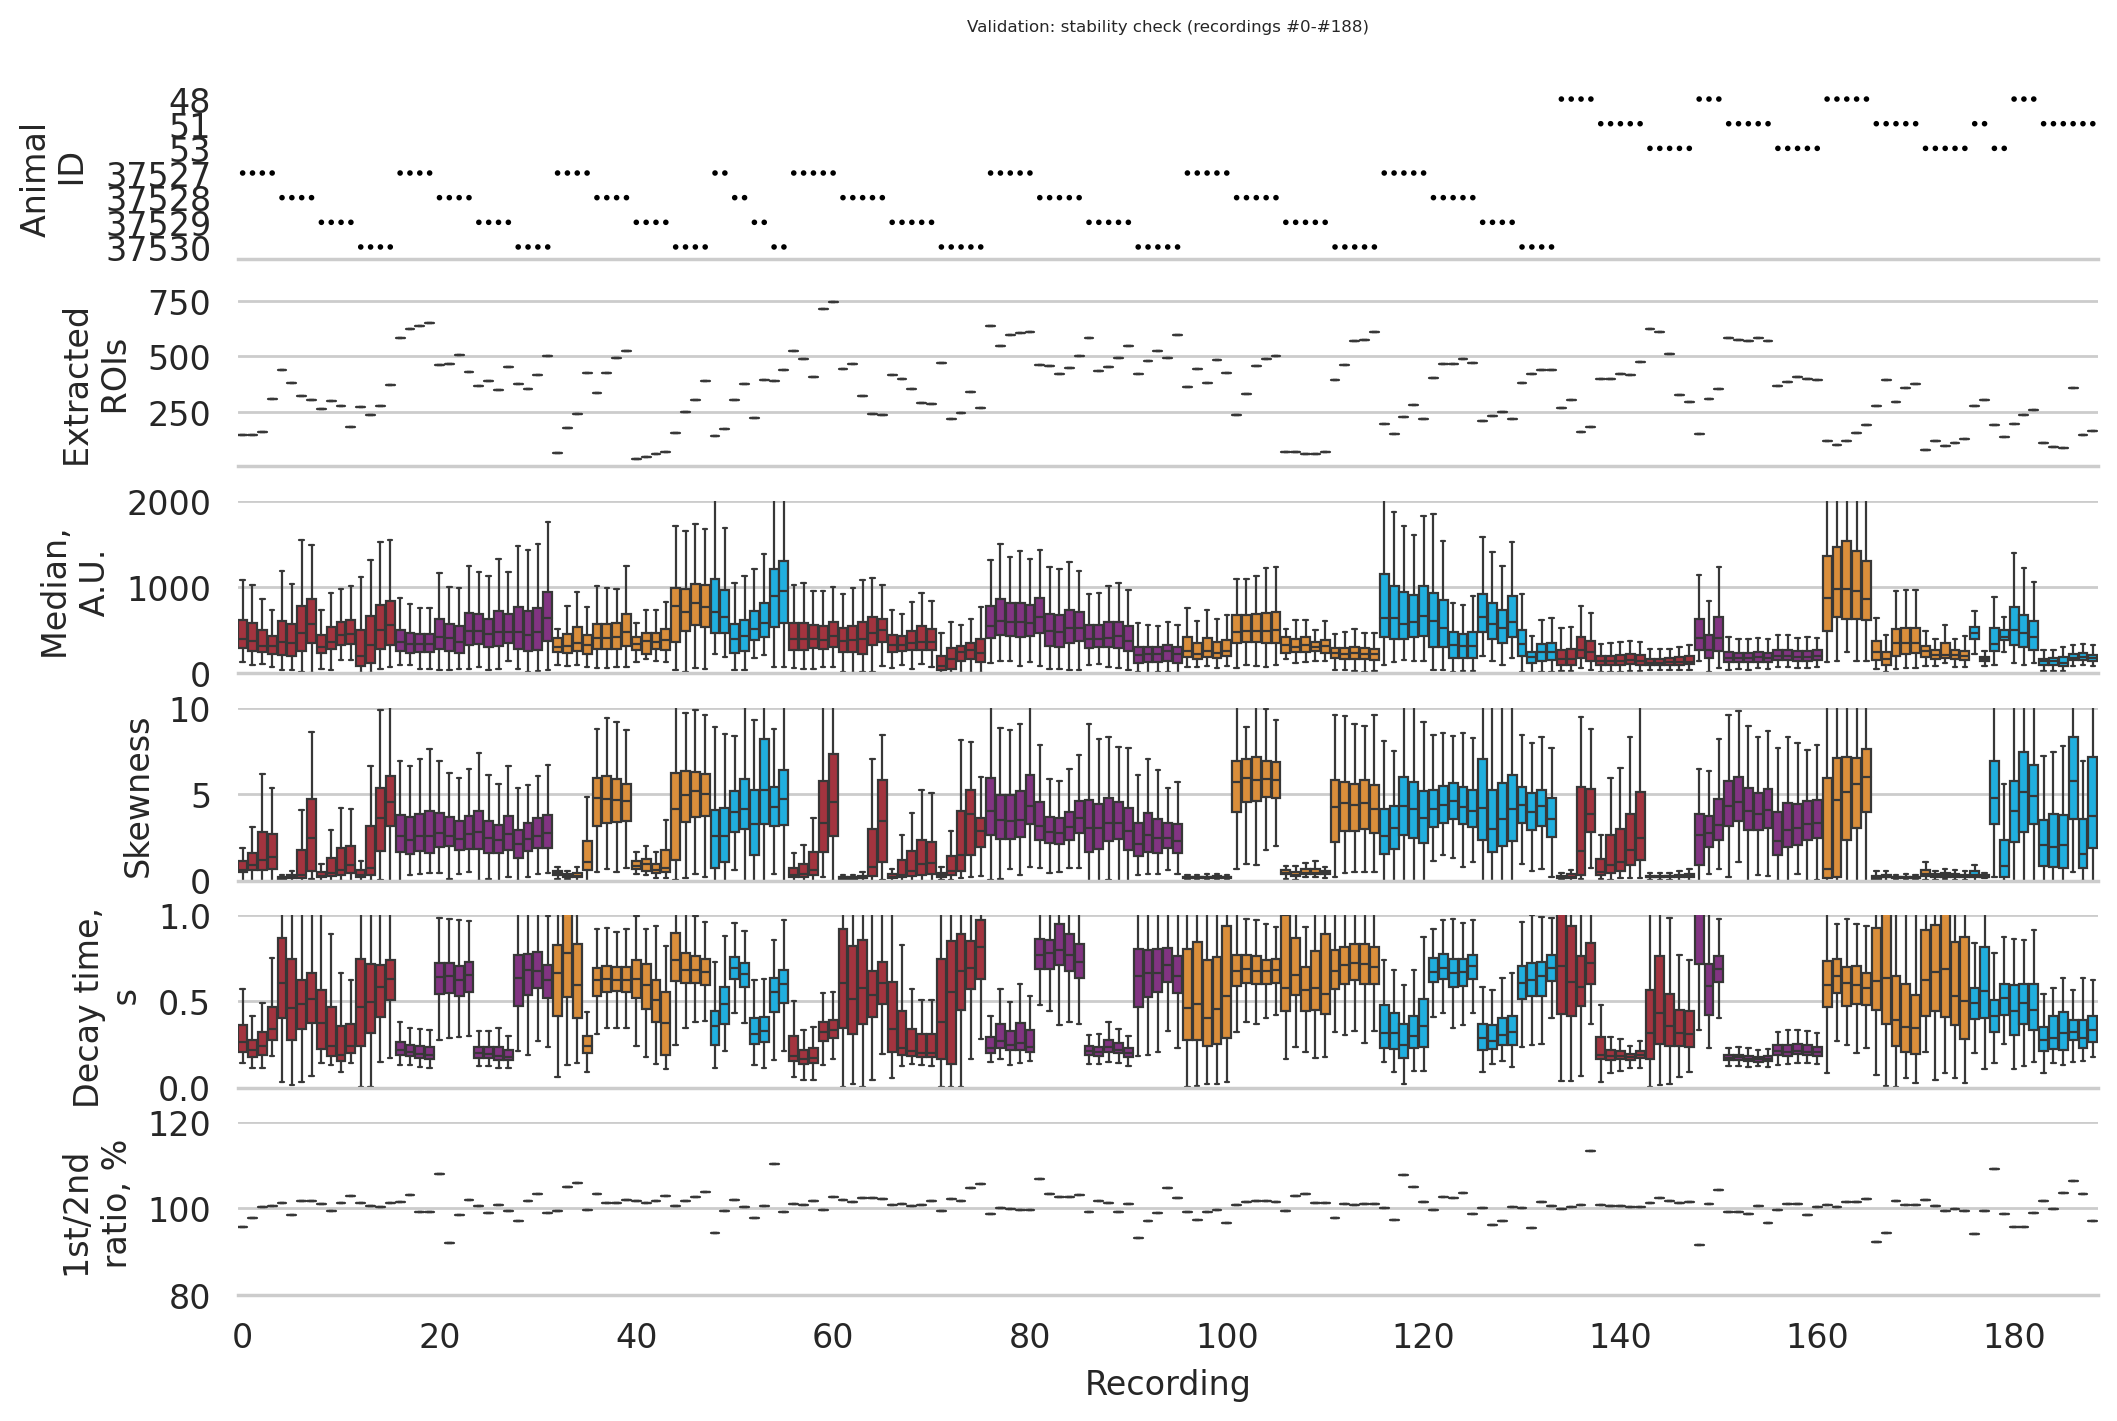

In [4]:
df_estimators["animal_cat"] = df_estimators["animal"].astype("category")

df_estimators['neuronID'] = df_estimators.index

parameters = ["animal",'number.neurons','traces.median','traces.skewness','decay','median.stability']
labels = ["Animal \n ID",'Extracted \n ROIs','Median, \n A.U.','Skewness','Decay time, \n s','1st/2nd \n ratio, %']
number_subplots = len(parameters)
recordings_ranges = [[0,188]]

for rmin,rmax in recordings_ranges:

    f, axes = plt.subplots(number_subplots, 1, figsize=(12, 8),dpi=200) # sharex=Truerex=True
    sns.despine(left=True)

    for i, param in enumerate(parameters):
        
        lw = 0.8

        #else:
        sns.boxplot(x='recording', y=param, data=df_estimators[(df_estimators.recording>=rmin)&(df_estimators.recording<=rmax)], width=0.9, dodge=False, showfliers = False,hue='condition', palette=custom_palette,ax=axes[i],linewidth=lw)
        if (i == 0):
            param = "animal_cat"
            print(np.unique(df_estimators[param]))
            axes[i].set_yticks(np.unique(df_estimators[param]))
 
            sns.swarmplot(x='recording', y=param, data=df_estimators[(df_estimators.recording>=rmin)&(df_estimators.recording<=rmax)&(df_estimators['neuronID'] == 0)],dodge=False,  s=1,  edgecolor='black', linewidth=1, hue='condition', palette=custom_palette, ax=axes[i])
            #ax.set(ylabel="")
      
        if i > 1:
            axes[i].set_ylim([0.0,2000.0])
        if i > 2:
            axes[i].set_ylim([0.0,10.0])
        if i > 3:
            axes[i].set_ylim([0.0,1.0])
        if i > 4:
            axes[i].set_ylim([80,120])
            axes[i].get_xaxis().set_visible(True)
        else:
            axes[i].get_xaxis().set_visible(False)
           
        if i < number_subplots-1:
            axes[i].xaxis.label.set_visible(False)
        if i==0:
            axes[i].set_title("Validation: stability check (recordings #%d-#%d)" % (rmin,rmax), fontsize=6, pad=20)
        axes[i].set_ylabel(labels[i], fontsize=12,labelpad=5)
        axes[i].set_xlabel("Recording", fontsize=12,labelpad=5)
        #axes[i].axis('off')

        axes[i].xaxis.set_tick_params(labelsize=12)
        axes[i].yaxis.set_tick_params(labelsize=12)

        axes[i].get_legend().remove()
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(20))
        axes[i].xaxis.set_major_formatter(ticker.ScalarFormatter())

        

    #plt.legend(loc='upper right',fontsize=8)
    #plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize=9)
    plt.savefig("Validation_stability_check_rec_#%d-#%d).png" % (rmin,rmax),dpi=300)
    plt.savefig("Validation_stability_check_rec_#%d-#%d).svg" % (rmin,rmax))
    #plt.show()